In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import cmocean
import pickle
from scipy import interpolate
from scipy import integrate
from scipy.interpolate import griddata 
from tqdm.notebook import tqdm
from altimetry_tools import Haversine, smooth_tracks, coarsen, specsharp

In [39]:
def filterSpec(N, dxMin, Lf, show_p, shape="Gaussian", X=np.pi):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        # F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(2/Lf)**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(np.pi/(X*Lf))**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
        # 2nd entry = (2/sMax)*(np.pi/(X*Lf))**2 -1  X = width of transition (~np.pi)
        # 3rd entry = nyquist wavelength on grid I'm filtering to
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    x = np.linspace(-1,1,251)
    k = np.sqrt((sMax/2)*(x+1))
    
    if show_p > 0:
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 2))
        ax1.plot(k,F(x),k,np.polynomial.chebyshev.chebval(x,p))
        ax2.plot(k,F(x)-np.polynomial.chebyshev.chebval(x,p))
        ax1.set_title('approx. filter')
        ax1.set_xlabel('step')
        ax2.set_title('target - approx. error')
        ax2.set_xlabel('step')
        ax2.set_ylim([-0.25, 0.25])
        plt.show()
        
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB


def Laplacian2D(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field. Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (x, y) whose Laplacian is computed
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, size size as 2nd dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Nx = np.size(field,0)
    Ny = np.size(field,1) # I suppose these could be inputs
    notLand = 1 - landMask
    # first compute Laplacian in y direction. "Right" is north and "Left" is south for this block
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxRight[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    fluxLeft = np.zeros((Nx,Ny))
    fluxLeft[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxLeft[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    OUT = (1/(dy**2))*(fluxRight - fluxLeft)
    # Now compute Laplacian in x direction and add it back in
    fluxRight = 0*fluxRight # re-set to zero just to be safe
    fluxLeft = 0*fluxLeft # re-set to zero just to be safe
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    OUT = OUT + (1/(dx**2))*(fluxRight - fluxLeft)
    return OUT*notLand

In [3]:
# load dataset
x1 = xr.open_dataset('/Users/jakesteinberg/Desktop/neverworld/snapshots_00032505.nc', decode_times=False)  

In [8]:
# -- load in a few variables 
lat = x1.yh.values
lon = x1.xh.values
time = x1.time.values

# grid distances in km
dist = np.zeros(len(lat))
# LAT (for each grid step in latitude, compute distance)
for i in range(1, len(lat)):
    dist[i] = 1852 * 60 * (lat[i] - lat[i - 1]) 
# LON (at each latitude, compute distance in the zonal direction )
dist_lon = np.zeros(len(lat))
for l in range(len(lat)):
    dx = 1852 * 60 * np.cos(np.deg2rad(lat[l])) * (lon[5] - lon[4])
    dy = 1852 * 60 * (lat[l] - lat[l]) 
    dist_lon[l] = np.sqrt(dx**2 + dy**2) 

dist_sum = np.cumsum(dist)
dist_lon_sum_0 = np.concatenate((np.zeros((len(lat), 1)), np.tile(dist_lon[:, None], (1, len(lon)-1))), axis=1)
dist_lon_sum = np.cumsum(dist_lon_sum_0, axis=1)
# 1/4 degree model (no real need to turn into km)      
print(str((dist_sum[2] - dist_sum[1])/1000) + ' km grid step')

# -- place u,v on KE grid 
u_lon = x1.xq.values
v_lat = x1.yq.values
u_reg = np.nan * np.ones((len(time), len(lat), len(lon)))
v_reg = np.nan * np.ones((len(time), len(lat), len(lon)))
for t in tqdm(range(len(time))):
    this_u = np.squeeze(x1.u.values[t, 0, :, :].copy())  # needs to be interpolated in lon direction
    this_v = np.squeeze(x1.v.values[t, 0, :, :].copy())  # needs to be interpolated in lat direction 
    for uu in range(len(lat)):
        u_reg[t, uu, :] = np.interp(lon, u_lon, this_u[uu, :])
    for vv in range(len(lon)):
        v_reg[t, :, vv] = np.interp(lat, v_lat, this_v[:, vv])

27.78 km grid step


smallest grid step = 9.55824846053608km
filtering factor = 6


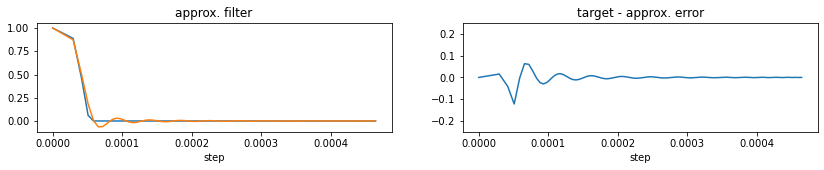

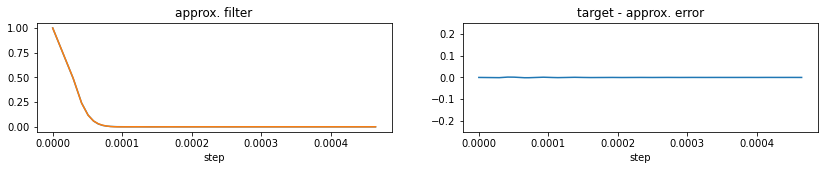

30 0
28 1


In [21]:
# Calculate Filter (for NON uniformly gridded data )
N = 30    # filter steps
N_g = 30
dxMin_test1 = dist_sum[2] - dist_sum[1]  # lat grid distance 
dxMin_test2 = np.nanmin(dist_lon)        # lon grid distance 
if dxMin_test1 < dxMin_test2:
    dxMin = dxMin_test1
else:
    dxMin = dxMin_test2
print('smallest grid step = ' + str(dxMin/1000.0) + 'km')

# note: for the lat/lon grid, the smallest grid step is something like 10 km, 
# so coarsening factor should not be the same as in the uniformly spaced grid
# in the above case we coarsened from 27km to ~ 110 km 
# say here we go from 10 to 100 km 
coarsening_factor = 6
Lf = dxMin*coarsening_factor  # filter scale 
print('filtering factor = ' + str(coarsening_factor))
NL, sL, NB, sB = filterSpec(N, dxMin, Lf, "Taper", X=np.pi)
NL_g, sL_g, NB_g, sB_g = filterSpec(N_g, np.int(dxMin), np.int(Lf), "Gaussian", X=np.pi)
print(NL,NB)
print(NL_g, NB_g)

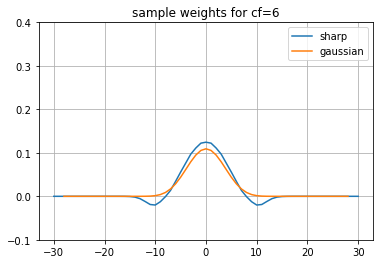

In [22]:
# -- new method 
L3 = (1/(np.int(dxMin)**2))*np.array([1,-2,1]) # The 1E4 in this line is 1/h^2 where h=0.01 is the assumed grid spacing.
L5 = (1/(np.int(dxMin)**2))*np.array([0,1,-2,1,0])
B = (1/(np.int(dxMin)**4))*np.array([1,-4,6,-4,1]) # The 1E8 in this line is 1/h^4
I3 = np.array([0,1,0])
I5 = np.array([0,0,1,0,0])
w = 1
for i in range(NL):
    w = np.convolve(I3 + (1/sL[i])*L3,w)
for i in range(NB):
    w = np.convolve(I5 + (2*np.real(sB[i])/np.abs(sB[i])**2)*L5 + (1/np.abs(sB[i])**2)*B, w)
    
w_g = 1
for i in range(NL_g):
    w_g = np.convolve(I3 + (1/sL_g[i])*L3,w_g)
for i in range(NB):
    w_g = np.convolve(I5 + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*L5 + (1/np.abs(sB_g[i])**2)*B, w_g)
    
f, ax = plt.subplots()
ax.plot(np.arange(-np.int(np.floor(len(w)/2)), np.int(np.floor(len(w)/2)) + 1), w, label='sharp')
ax.plot(np.arange(-np.int(np.floor(len(w_g)/2)), np.int(np.floor(len(w_g)/2)) + 1), w_g, label='gaussian')
# ax.plot(np.arange(-np.int(np.floor(len(filter_weights)/2)), np.int(np.floor(len(filter_weights)/2)) + 1), \
#                    filter_weights, color='r', label='originial sharp')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_title('sample weights for cf=' + str(coarsening_factor))
ax.set_ylim([-.1, .4])
ax.grid()
plt.show()

In [23]:
# Filtering prep
Nx = np.shape(dist_lon_sum)[1]                 # length lon points
Ny = len(dist_sum)                             # length lat points 
dy = dist_sum[2] - dist_sum[1]                 # grid spacing (1 value)
dx = dist_lon_sum[:, 2] - dist_lon_sum[:, 1]   # lon grid spacing (function of lat, should be Ny long)

# define land mask based on nan bounds of model domain
landMask = 0*np.random.randint(0,2,(Nx,Ny))
landMask[np.isnan(np.transpose(u_reg[0, :, :]))] = 1
landMask[np.transpose(u_reg[0, :, :] == 0)] = 1
landMask[np.isnan(np.transpose(v_reg[t, :, :]))] = 1
landMask[np.transpose(v_reg[t, :, :] == 0)] = 1

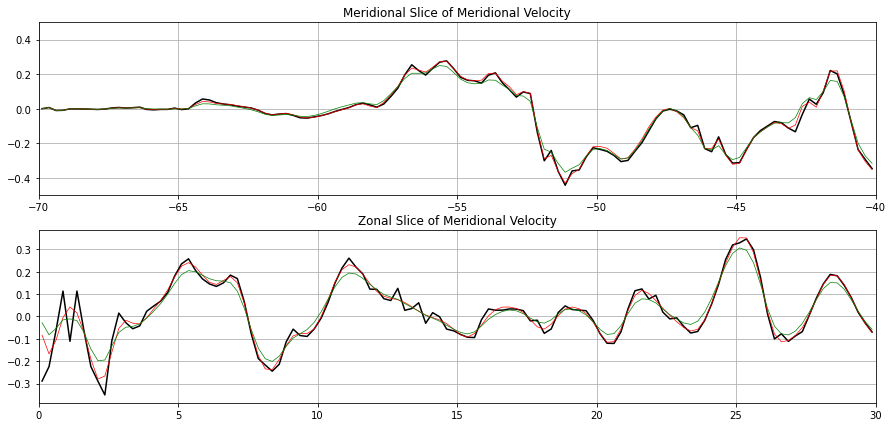

In [28]:
# TEST 1 time SLICE 
test = np.squeeze(v_reg[10, :, :].copy())
# -- mirror lon bounds (not needed)
test0 = test.copy()
test[:, 0:4] = np.fliplr(test[:, 5:9])
test[:, -4:] = np.fliplr(test[:, -9:-5])
# -- mirror lat bounds (needed?)
# u
# test[0:3, :] = np.flipud(test[4:7, :])
# test[-3:, :] = np.flipud(test[-7:-4, :])
# v 
test[0:4, :] = np.flipud(test[4:8, :]) + 0.0001*np.random.randint(-100, 100, np.shape(test[4:8, :]))
test[-4:, :] = np.flipud(test[-8:-4, :]) + 0.0001*np.random.randint(-100, 100, np.shape(test[4:8, :]))

field = np.transpose(test.copy())
data_test = field.copy()
data_test_g = field.copy()
tempL_out = np.nan * np.ones((NL_2d, np.shape(field)[0], np.shape(field)[1]))
for i in range(NL_2d):
    tempL = Laplacian2D(data_test,landMask,dx,dy)
    tempL_out[i, :, :] = tempL.copy()
    data_test = data_test + (1/sL_2d[i])*tempL # Update filtered field
for i in range(NB_2d):
    tempL = Laplacian2D(data_test, landMask, dx, np.int(dy))
    tempB = Laplacian2D(tempL, landMask, dx, np.int(dy))
    data_test = data_test + (2*np.real(sB_2d[i])/(np.abs(sB_2d[i])**2))*tempL + (1/(np.abs(sB_2d[i])**2))*tempB
for i in range(NL_2d_g):
    tempL = Laplacian2D(data_test_g,landMask,dx,dy)
    tempL_out[i, :, :] = tempL.copy()
    data_test_g = data_test_g + (1/sL_2d_g[i])*tempL # Update filtered field
for i in range(NB_2d_g):
    tempL = Laplacian2D(data_test_g, landMask, dx, np.int(dy))
    tempB = Laplacian2D(tempL, landMask, dx, np.int(dy))
    data_test_g = data_test_g + (2*np.real(sB_2d_g[i])/(np.abs(sB_2d_g[i])**2))*tempL + \
        (1/(np.abs(sB_2d_g[i])**2))*tempB
    
f, (ax, ax2) = plt.subplots(2, 1, figsize=(15,7))
ax.plot(lat[0:120], field[50, 0:120], linewidth=1.5, color='k')
ax.plot(lat[0:120], data_test[50, 0:120], linewidth=0.7, color='r')
ax.plot(lat[0:120], data_test_g[50, 0:120], linewidth=0.7, color='g')
ax.set_ylim([-.5, .5])
ax.set_xlim([-70, -40])
ax.set_title('Meridional Slice of Meridional Velocity')
ax.grid()

ax2.set_title('Zonal Slice of Meridional Velocity')
ax2.plot(lon[0:120], field[0:120, 50], linewidth=1.5, color='k')
ax2.plot(lon[0:120], data_test[0:120, 50], linewidth=0.7, color='r')
ax2.plot(lon[0:120], data_test_g[0:120, 50], linewidth=0.7, color='g')
ax2.set_xlim([0, 30])
ax2.grid()
plt.show()  

In [57]:
# FULL 2D
def filt2d(u_reg, v_reg, landMask, dx, dy, NL_2d, sL_2d, NB_2d, sB_2d):
    # Laplacian (for non-uniform grid)
    u_filtered_2 = np.nan * np.ones(np.shape(u_reg))
    v_filtered_2 = np.nan * np.ones(np.shape(v_reg))
    u_filtered_2_g = np.nan * np.ones(np.shape(u_reg))
    v_filtered_2_g = np.nan * np.ones(np.shape(v_reg))
    for t in tqdm(range(np.shape(u_reg)[0])):  
        uBar_master = np.squeeze(u_reg[t, :, :].copy()) 
        vBar_master = np.squeeze(v_reg[t, :, :].copy()) 
        # -- reflect edges 
        uBar_master[:, 0:4] = np.fliplr(uBar_master[:, 5:9])
        uBar_master[:, -4:] = np.fliplr(uBar_master[:, -9:-5])
        uBar_master[0:3, :] = np.flipud(uBar_master[4:7, :])
        uBar_master[-3:, :] = np.flipud(uBar_master[-7:-4, :])
        vBar_master[:, 0:4] = np.fliplr(vBar_master[:, 5:9])
        vBar_master[:, -4:] = np.fliplr(vBar_master[:, -9:-5])
        vBar_master[0:4, :] = np.flipud(vBar_master[4:8, :])
        vBar_master[-4:, :] = np.flipud(vBar_master[-8:-4, :])
    
        # u,v
        dataBar = np.transpose(uBar_master.copy())
        dataBar2 = np.transpose(vBar_master.copy())
        for i in range(NL_2d):
            tempL = Laplacian2D(dataBar, landMask, dx, np.int(dy))
            dataBar = dataBar + (1/sL_2d[i])*tempL # Update filtered field
            tempL2 = Laplacian2D(dataBar2, landMask, dx, np.int(dy))
            dataBar2 = dataBar2 + (1/sL_2d[i])*tempL2 # Update filtered field
        for i in range(NB_2d):
            tempL = Laplacian2D(dataBar, landMask, dx, np.int(dy))
            tempB = Laplacian2D(tempL, landMask, dx, np.int(dy))
            dataBar = dataBar + (2*np.real(sB_2d[i])/(np.abs(sB_2d[i])**2))*tempL + (1/(np.abs(sB_2d[i])**2))*tempB          
            tempL2 = Laplacian2D(dataBar2, landMask, dx, np.int(dy))
            tempB2 = Laplacian2D(tempL2, landMask, dx, np.int(dy))
            dataBar2 = dataBar2 + (2*np.real(sB_2d[i])/(np.abs(sB_2d[i])**2))*tempL2 + (1/(np.abs(sB_2d[i])**2))*tempB2
        u_filtered_2[t, :, :] = np.transpose(dataBar)   
        v_filtered_2[t, : , :] = np.transpose(dataBar2)

    return(u_filtered_2, v_filtered_2)

In [144]:
# loop over filter scales to determine if there is a dependence of u_prime*u_bar or filter scale 
Lf_list = dxMin * np.array([3, 5, 7, 9, 11])
u_filt_out = np.nan * np.ones((len(Lf_list), np.shape(u_reg)[0], np.shape(u_reg)[1], np.shape(u_reg)[2]))
v_filt_out = np.nan * np.ones((len(Lf_list), np.shape(u_reg)[0], np.shape(u_reg)[1], np.shape(u_reg)[2]))
for i in range(len(Lf_list)):
    NL, sL, NB, sB = filterSpec(N, dxMin, Lf_list[i], 0, "Taper", X=np.pi)
    u_filt_i, v_filt_i = filt2d(u_reg, v_reg, landMask, dx, dy, NL, sL, NB, sB)
    u_filt_out[i, :, :, :] = u_filt_i.copy()
    v_filt_out[i, :, :, :] = v_filt_i.copy()

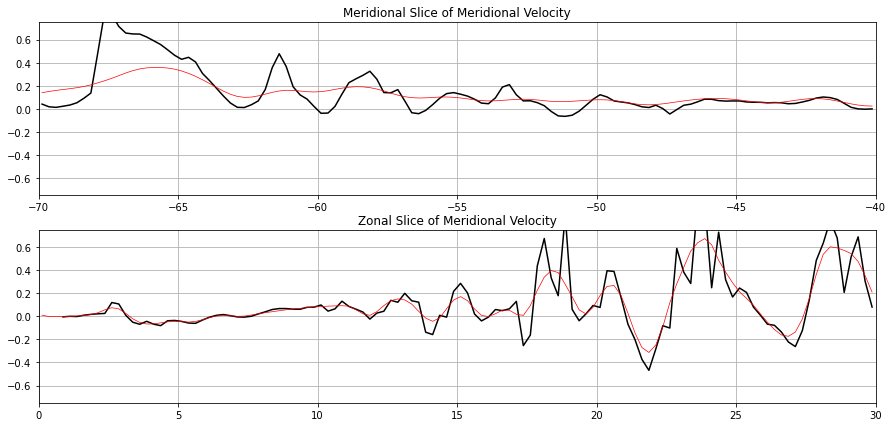

In [145]:
f, (ax, ax2) = plt.subplots(2, 1, figsize=(15,7))
ax.plot(lat[0:120], u_reg[0, 50, 0:120], linewidth=1.5, color='k')
ax.plot(lat[0:120], u_filt_out[2, 0, 50, 0:120], linewidth=0.7, color='r')
ax.set_ylim([-.75, .75])
ax.set_xlim([-70, -40])
ax.set_title('Meridional Slice of Meridional Velocity')
ax.grid()

ax2.set_title('Zonal Slice of Meridional Velocity')
ax2.plot(lon[0:120], u_reg[0, 0:120, 50], linewidth=1.5, color='k')
ax2.plot(lon[0:120], u_filt_out[2, 0, 0:120, 50], linewidth=0.7, color='r')
ax2.set_xlim([0, 30])
ax2.set_ylim([-.75, .75])
ax2.grid()
plt.show()  

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


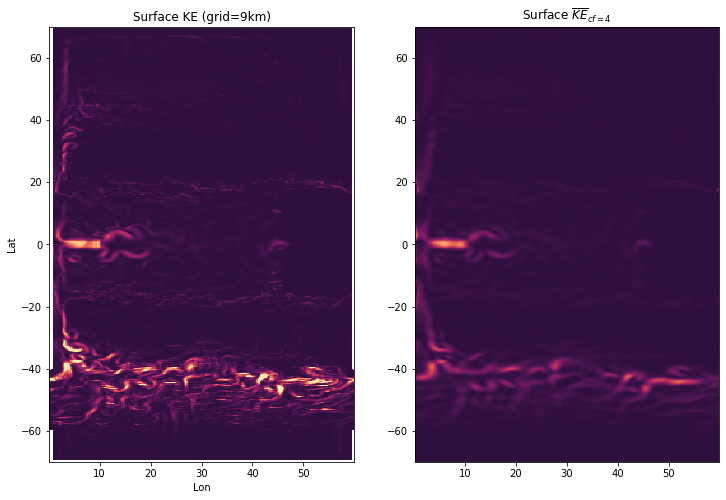

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


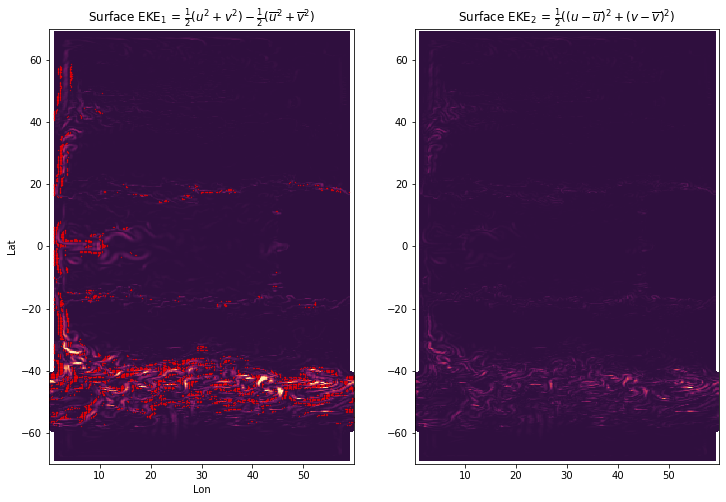

In [143]:
t_i = 0
filter_index = 4

ke = (0.5)*(u_reg**2 + v_reg**2)
kebar = (0.5)*(u_filt_out[filter_index]**2 + v_filt_out[filter_index]**2)
eke = ke - kebar
eke_2 = (0.5)*(np.square(u_reg-u_filt_out[filter_index]) + np.square(v_reg-v_filt_out[filter_index]))
upr_ubar = u_filt_out*(u_reg-u_filt_out)
vpr_vbar = v_filt_out*(v_reg-v_filt_out)

neg_mask = np.zeros(np.shape(eke))
for i in range(np.shape(eke)[0]):
    bad = np.where(eke[i, :, :] < 0)
    neg_mask_i = neg_mask[i, :, :]
    neg_mask_i[bad] = 1

f, (ax, ax2) = plt.subplots(1, 2, figsize=(12,8))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[t_i, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
ax.set_title('Surface KE (grid=' + str(np.int(dxMin/1000)) + 'km)')
ax2.pcolormesh(x1.xh, x1.yh, kebar[t_i], cmap = cmocean.cm.matter_r, zorder=0, vmin=levs[0], vmax=levs[-1])
ax2.set_title('Surface $\overline{KE}_{cf=4}$')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()

# --- EKE 
# levs = np.linspace(7*10**(-8), 7*10**(-3), 100)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,8))
ax3.pcolormesh(x1.xh, x1.yh, eke[t_i], cmap = cmocean.cm.matter_r, zorder=0, vmin=levs[0], vmax=levs[-1])
ax3.set_title(r'Surface EKE$_1$ = $\frac{1}{2}(u^2 + v^2) - \frac{1}{2}(\overline{u}^2 + \overline{v}^2)$')

Lon_mesh, Lat_mesh = np.meshgrid(np.nan*np.zeros(len(lon)), np.nan*np.zeros(len(lat)))
for i in range(len(lat)):
    eke_neg_i = np.where(eke[t_i][i, :] < -0.01)[0]
    Lon_mesh[i, eke_neg_i] = lon[eke_neg_i]
    Lat_mesh[i, eke_neg_i] = np.ones(len(eke_neg_i)) * lat[i]
ax3.scatter(Lon_mesh, Lat_mesh, color='r', s=0.1)

ax4.pcolormesh(x1.xh, x1.yh, eke_2[t_i], cmap =cmocean.cm.matter_r, zorder=0, vmin=levs[0], vmax=levs[-1])
ax4.set_title(r'Surface EKE$_2$ = $\frac{1}{2}((u-\overline{u})^2 + (v-\overline{v})^2)$')
ax3.set_xlabel('Lon')
ax3.set_ylabel('Lat')
plt.show()

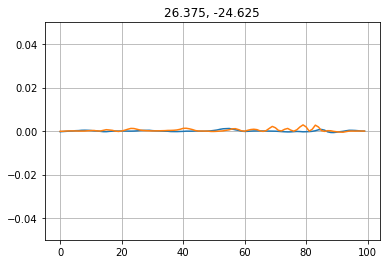

In [113]:
lat_ind = 181
lon_ind = 105
f, ax = plt.subplots()
# ax.plot(np.arange(0, np.shape(u_filt_out[0])[0]), u_reg[:, 100, 100])
# ax.plot(np.arange(0, np.shape(u_filt_out[0])[0]), np.squeeze(u_filt_out[0][:, 100, 100]))
ax.plot(np.arange(0, np.shape(u_filt_out[0])[0]), \
        (u_reg[:, lat_ind, lon_ind]**2 - np.squeeze(u_filt_out[0][:, lat_ind, lon_ind])**2))
ax.plot(np.arange(0, np.shape(v_filt_out[0])[0]), \
        (v_reg[:, lat_ind, lon_ind]**2 - np.squeeze(v_filt_out[0][:, lat_ind, lon_ind])**2))
ax.set_ylim([-.05, .05])
ax.set_title(str(lon[lon_ind]) + ', ' + str(lat[lat_ind]))
ax.grid()
plt.show()

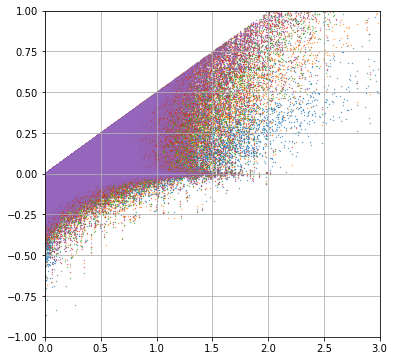

In [137]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(ke, upr_ubar[0], s=0.1)
ax.scatter(ke, upr_ubar[1], s=0.1)
ax.scatter(ke, upr_ubar[2], s=0.1)
ax.scatter(ke, upr_ubar[3], s=0.1)
ax.scatter(ke, upr_ubar[4], s=0.1)
ax.set_ylim([-1, 1])
ax.set_xlim([0, 3])
ax.grid()
plt.show()

In [138]:
outie = np.nan * np.ones(len(Lf_list))
for filter_index in range(len(Lf_list)):
    kebar = (0.5)*(u_filt_out[filter_index]**2 + v_filt_out[filter_index]**2)
    eke = ke - kebar
    neg_mask = np.zeros(np.shape(eke))
    for i in range(np.shape(eke)[0]):
        bad = np.where(eke[i, :, :] < 0)
        neg_mask_i = neg_mask[i, :, :]
        neg_mask_i[bad] = 1
    outie[filter_index] = np.nansum(neg_mask_i)

# as the filter width increases, the number of negative eke points goes downnnn 

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [139]:
outie

array([38608., 38636., 38399., 38595., 38927.])

In [134]:
outie

array([67500., 65885., 42420., 39463., 39509.])